## Merging Files

In [1]:
import csv

# Generate filenames programmatically
path = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTBBE/1000simXgb3_2000mData"
files = [path + "/getXGBoostTrainingData_{}.csv".format(i) for i in range(1000)]

merged_filename = "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb4Training/XGB_merged_result.csv"

with open(merged_filename, "w", newline="") as outfile:
    writer = csv.writer(outfile)

    for index, filename in enumerate(files):
        with open(filename, "r") as infile:
            reader = csv.reader(infile)

            # Skip header only if it's not the first file
            if index != 0:
                next(reader, None)

            # Write rows from current file to the output file
            writer.writerows(reader)

## Sorting values by balance

In [2]:
import pandas as pd

# Read the merged CSV file into a DataFrame
df = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb4Training/XGB_merged_result.csv"
)

# Sort the DataFrame by balance in descending order
df_sorted = df.sort_values(by="balance", ascending=False)

df_sorted.head(100)

,type,competitorID,time,exchange,odds,agentID,stake,distance,rank,balance,decision
2143212,Trade,4,197.301733,0,2.300000,16,15,1915.011808,1,1.001553e+08,backer
2140428,Trade,4,192.820309,0,5.184588,16,15,1861.192817,1,1.001553e+08,backer
2140398,Trade,4,192.808090,0,5.184588,16,15,1861.192817,1,1.001553e+08,backer
2140400,Trade,4,192.808478,0,5.149287,16,15,1861.192817,1,1.001553e+08,backer
2140402,Trade,4,192.808908,0,5.149287,16,15,1861.192817,1,1.001553e+08,backer
...,...,...,...,...,...,...,...,...,...,...,...
2140606,Trade,4,192.964873,0,5.186258,16,15,1861.192817,1,1.001553e+08,backer
2140608,Trade,4,192.965896,0,5.186258,16,15,1861.192817,1,1.001553e+08,backer
2140610,Trade,4,192.966354,0,6.134254,16,15,1861.192817,1,1.001553e+08,backer
2140612,Trade,4,192.966776,0,6.134254,16,15,1861.192817,1,1.001553e+08,backer


## Saving top 20% of values for training

In [3]:
# Calculate 20% of the total number of rows and retrieve the top rows
top_20_percent = int(0.20 * len(df_sorted))
top_20_df = df_sorted.head(top_20_percent)

# Save the top 20% rows to a new CSV file, if desired
top_20_df.to_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb4Training/XGB_Top_20%.csv",
    index=False,
)

## Pre-processing and splitting of data

In [4]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 1. Import the data
data = pd.read_csv(
    "/Volumes/T9/XGBoost_OD_TBBE/XGBoostTraining/dataXgb4Training/XGB_Top_20%.csv"
)
decision_counts = data["decision"].value_counts()
print(decision_counts)


# Remove potentially irrelevant columns
data = data.drop(
    columns=["type", "competitorID", "exchange", "agentID", "balance", "odds"]
)

# Column that has left: time  odds  stake  distance  rank

# Convert 'decision' column to binary: 1 for 'backer' and 0 for 'layer'
data["decision"] = data["decision"].map({"backer": 1, "layer": 0})

# Split data into training and testing sets
X = data.drop(columns="decision")
print(X.head())
y = data["decision"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

decision
layer     1241805
backer    1154091
Name: count, dtype: int64
         time  stake     distance  rank
0  197.301733     15  1915.011808     1
1  192.820309     15  1861.192817     1
2  192.808090     15  1861.192817     1
3  192.808478     15  1861.192817     1
4  192.808908     15  1861.192817     1


## Model Training

In [5]:
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report


# Define the function to optimize
def bo_tune_xgb(eta, max_depth, subsample, colsample_bytree, gamma, alpha, lambda_):
    params = {
        "eta": eta,
        "max_depth": int(max_depth),
        "subsample": subsample,
        "colsample_bytree": colsample_bytree,
        "gamma": gamma,
        "alpha": alpha,
        "lambda": lambda_,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "n_estimators": 100,
        "random_state": 42,
    }
    cv_result = xgb.cv(params, dtrain, nfold=5)
    y_pred = xgb.train(params, dtrain, num_boost_round=100).predict(xgb.DMatrix(X_test))
    y_pred = [1 if pred > 0.5 else 0 for pred in y_pred]  # Apply threshold
    return accuracy_score(y_test, y_pred)


# Convert training data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the bounds of the hyperparameters to optimize
hyperparameter_space = {
    "eta": (0.1, 0.6),
    "max_depth": (5, 8),
    "subsample": (0.5, 1.0),
    "colsample_bytree": (0.5, 1.0),
    "gamma": (0, 0.4),
    "alpha": (0, 2.0),
    "lambda_": (0, 3.0),
}

# Initialize Bayesian optimizer
optimizer = BayesianOptimization(
    f=bo_tune_xgb, pbounds=hyperparameter_space, random_state=42, verbose=2
)

# Perform optimization
optimizer.maximize(init_points=5, n_iter=50)

# Print best parameters and score
print("Best parameters found:", optimizer.max["params"])
print("Best cross-validation score:", optimizer.max["target"])

# Use the best model for prediction and evaluation
best_params = optimizer.max["params"]
best_params["max_depth"] = int(best_params["max_depth"])
best_model = xgb.train(best_params, dtrain, num_boost_round=100)

y_pred_best = best_model.predict(xgb.DMatrix(X_test))
y_pred_best = [1 if pred > 0.5 else 0 for pred in y_pred_best]  # Apply threshold
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Accuracy (Best Model):", accuracy_best)
print(classification_report(y_test, y_pred_best))

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   |  lambda_  | max_depth | subsample |
-------------------------------------------------------------------------------------------------------------


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:08:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:08:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 1         | 0.8202    | 0.7491    | 0.9754    | 0.466     | 0.2395    | 0.4681    | 5.468     | 0.529     |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 2         | 0.8374    | 1.732     | 0.8006    | 0.454     | 0.008234  | 2.91      | 7.497     | 0.6062    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 3         | 0.8046    | 0.3636    | 0.5917    | 0.2521    | 0.2099    | 1.296     | 5.874     | 0.8059    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:09:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 4         | 0.8062    | 0.279     | 0.6461    | 0.2832    | 0.1824    | 2.356     | 5.599     | 0.7571    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 5         | 0.8189    | 1.185     | 0.5232    | 0.4038    | 0.06821   | 0.1952    | 7.847     | 0.9828    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 6         | 0.8694    | 2.0       | 1.0       | 0.6       | 0.3624    | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:10:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 7         | 0.8679    | 2.0       | 1.0       | 0.6       | 0.4       | 2.241     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 8         | 0.8696    | 0.3774    | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 9         | 0.87      | 0.0       | 1.0       | 0.6       | 0.4       | 1.927     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:11:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 10        | 0.8324    | 0.0       | 1.0       | 0.1       | 0.4       | 2.589     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 11        | 0.8302    | 0.9231    | 0.5       | 0.6       | 0.4       | 2.282     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 12        | 0.8336    | 2.0       | 1.0       | 0.1       | 0.4       | 2.638     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:12:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 13        | 0.8213    | 0.2382    | 0.9752    | 0.5842    | 0.3813    | 2.775     | 5.709     | 0.7107    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 14        | 0.8223    | 1.953     | 0.8499    | 0.5514    | 0.1779    | 1.224     | 5.721     | 0.5895    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 15        | 0.8166    | 0.8566    | 0.6636    | 0.3588    | 0.3926    | 0.05051   | 7.672     | 0.7597    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 16        | 0.8052    | 0.01295   | 0.7415    | 0.2454    | 0.2345    | 1.533     | 5.479     | 0.9832    |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:13:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 17        | 0.8621    | 0.0       | 1.0       | 0.6       | 0.0       | 2.505     | 7.826     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 18        | 0.8711    | 0.0       | 1.0       | 0.6       | 0.0       | 1.357     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:39] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 19        | 0.8631    | 0.0       | 1.0       | 0.6       | 0.4       | 1.47      | 7.402     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:14:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 20        | 0.8622    | 0.0       | 1.0       | 0.6       | 0.4       | 3.0       | 7.231     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 21        | 0.8715    | 2.0       | 1.0       | 0.6       | 0.0       | 1.409     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 22        | 0.8629    | 2.0       | 1.0       | 0.6       | 0.0       | 1.659     | 7.271     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:15:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 23        | 0.8668    | 2.0       | 1.0       | 0.6       | 0.4       | 1.393     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 24        | 0.8345    | 2.0       | 1.0       | 0.6       | 0.4       | 3.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 25        | 0.8335    | 0.0       | 1.0       | 0.1       | 0.4       | 1.084     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:16:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 26        | 0.8599    | 0.0       | 1.0       | 0.6       | 0.0       | 1.606     | 7.782     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 27        | 0.8715    | 0.9035    | 1.0       | 0.6       | 0.0       | 1.477     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:17:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 28        | 0.8701    | 1.1       | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 29        | 0.8661    | 2.0       | 1.0       | 0.6       | 0.0       | 1.944     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 30        | 0.8632    | 0.4229    | 1.0       | 0.6       | 0.0       | 1.746     | 7.629     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:18:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 31        | 0.8706    | 1.53      | 1.0       | 0.6       | 0.4       | 1.484     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 32        | 0.8667    | 1.39      | 1.0       | 0.6       | 0.0       | 1.281     | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 33        | 0.8709    | 1.552     | 1.0       | 0.6       | 0.0       | 1.849     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:19:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 34        | 0.8087    | 2.0       | 0.5       | 0.6       | 0.4       | 0.0       | 5.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 35        | 0.862     | 1.07      | 1.0       | 0.6       | 0.4       | 3.0       | 7.571     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 36        | 0.8644    | 2.0       | 1.0       | 0.6       | 0.4       | 0.9887    | 7.51      | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:20:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 37        | 0.8702    | 2.776e-17 | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 38        | 0.8634    | 1.424     | 1.0       | 0.6       | 0.0       | 1.289     | 7.684     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 39        | 0.87      | 0.4411    | 1.0       | 0.6       | 0.4       | 1.412     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:21:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 40        | 0.8684    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 41        | 0.8674    | 2.0       | 1.0       | 0.6       | 0.0       | 0.6953    | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:28] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:29] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 42        | 0.8596    | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 7.102     | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:22:50] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 43        | 0.8684    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 44        | 0.8696    | 2.0       | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:19] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 45        | 0.8688    | 0.0       | 1.0       | 0.6       | 0.4       | 3.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 46        | 0.8712    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:54] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:23:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 47        | 0.8701    | 2.0       | 1.0       | 0.6       | 0.4       | 0.6669    | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 48        | 0.8709    | 0.2299    | 1.0       | 0.6       | 0.0       | 1.675     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:27] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 49        | 0.8686    | 2.0       | 1.0       | 0.6       | 0.4       | 1.571     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 50        | 0.872     | 2.0       | 1.0       | 0.6       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:24:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 51        | 0.8331    | 2.0       | 1.0       | 0.1       | 0.0       | 0.0       | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:21] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 52        | 0.8621    | 2.0       | 1.0       | 0.6       | 0.4       | 0.0       | 7.483     | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 53        | 0.8663    | 0.5513    | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 0.5       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:25:55] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.

| 54        | 0.8713    | 2.0       | 1.0       | 0.6       | 0.0       | 2.079     | 8.0       | 1.0       |


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:26:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:26:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:26:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


| 55        | 0.8699    | 0.5347    | 1.0       | 0.6       | 0.0       | 3.0       | 8.0       | 1.0       |
Best parameters found: {'alpha': 2.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.0, 'lambda_': 0.0, 'max_depth': 8.0, 'subsample': 1.0}
Best cross-validation score: 0.8719729537960683


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [13:26:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy (Best Model): 0.8697754497266164
              precision    recall  f1-score   support

           0       0.86      0.89      0.88    248200
           1       0.88      0.85      0.86    230980

    accuracy                           0.87    479180
   macro avg       0.87      0.87      0.87    479180
weighted avg       0.87      0.87      0.87    479180



## Boxplot of parameters


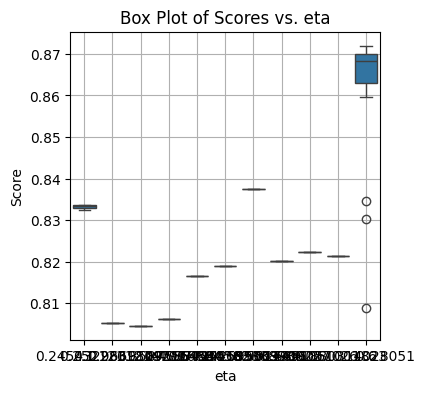

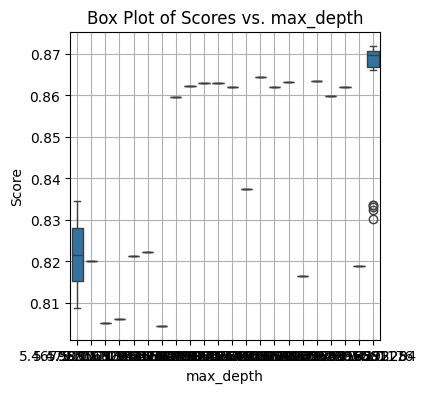

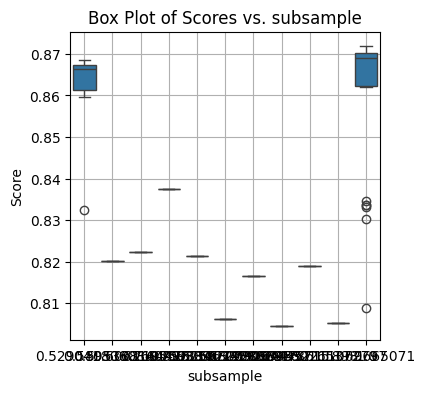

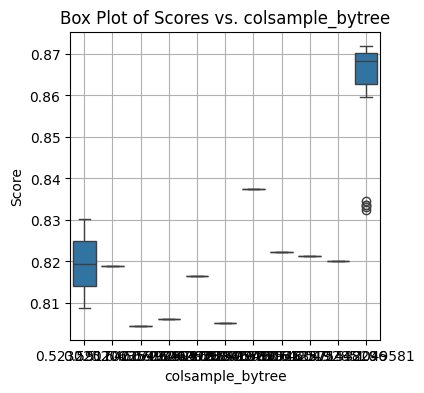

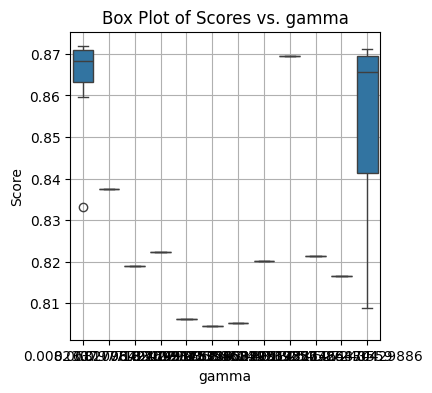

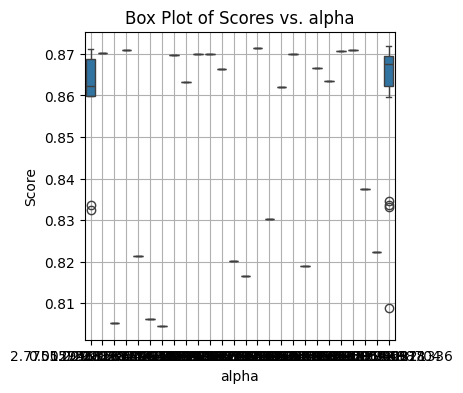

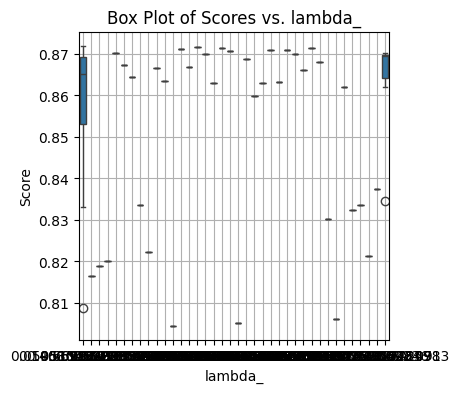

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert the optimization results to a dataframe
results_df = pd.DataFrame(optimizer.res)

# Extract the parameters into separate columns
for param in hyperparameter_space.keys():
    results_df[param] = results_df["params"].apply(lambda params: params[param])

# Melt the dataframe for seaborn
melted_scores_df = results_df.melt(
    id_vars=list(hyperparameter_space.keys()),
    value_vars=["target"],
    var_name="iteration",
    value_name="score",
)

for param in hyperparameter_space.keys():
    plt.figure(figsize=(4, 4))

    # Boxplot
    sns.boxplot(data=melted_scores_df, x=param, y="score")
    plt.title(f"Box Plot of Scores vs. {param}")
    plt.ylabel("Score")
    plt.grid(True)
    plt.show()

## Model evaluation and performance visualisation 

Accuracy: 0.8697754497266164

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88    248200
           1       0.88      0.85      0.86    230980

    accuracy                           0.87    479180
   macro avg       0.87      0.87      0.87    479180
weighted avg       0.87      0.87      0.87    479180



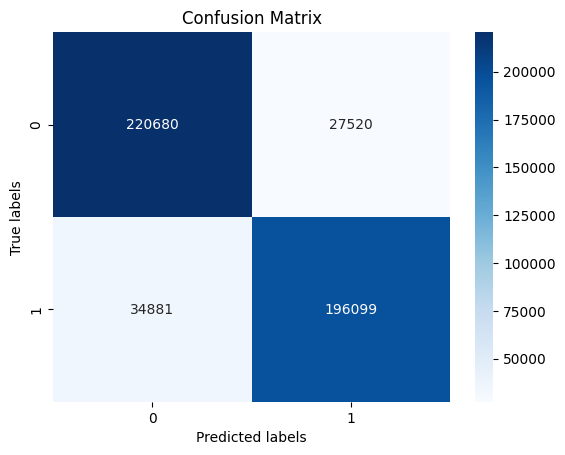

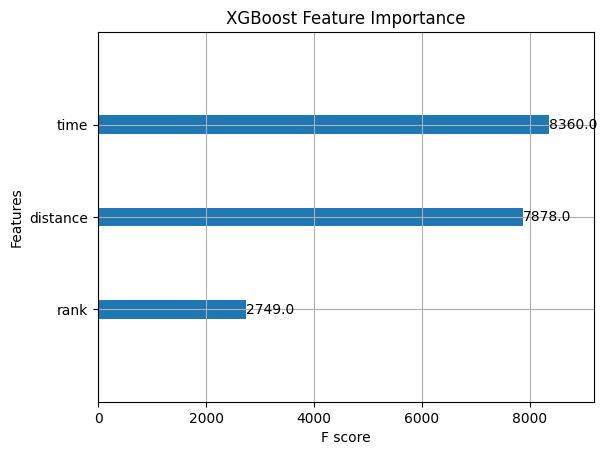

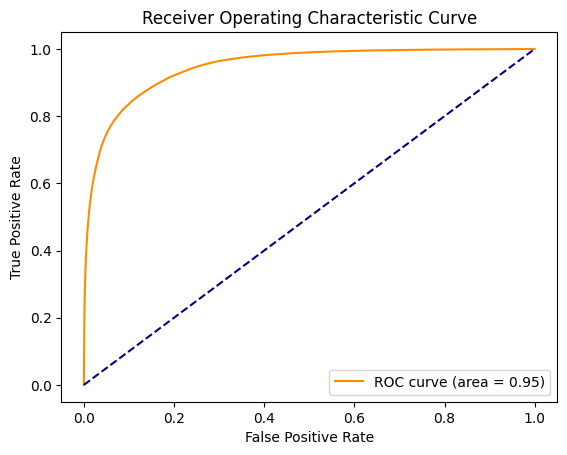

PR AUC: 0.9430021853317208


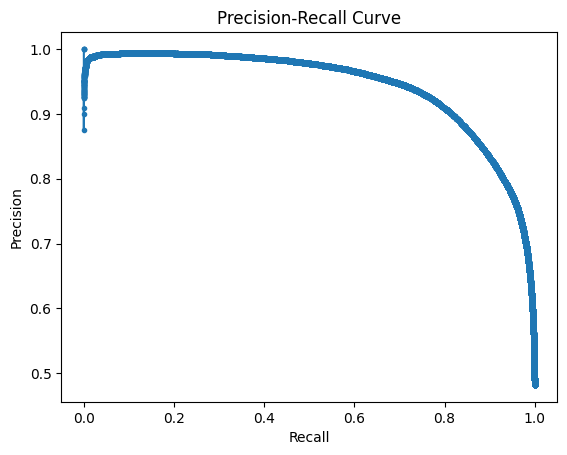

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
)
import seaborn as sns
import joblib

# 1. Testing on the Test Set
y_pred = y_pred_best

# 2. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# 3. Visualization

# Feature Importance
xgb.plot_importance(best_model)
plt.title("XGBoost Feature Importance")
plt.show()

# ROC Curve
y_pred_proba = best_model.predict(xgb.DMatrix(X_test))
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.plot(recall, precision, marker=".")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
# Compute and print AUC for Precision-Recall Curve
pr_auc = auc(recall, precision)
print(f"PR AUC: {pr_auc}")
plt.show()

## Train-test error progression plot

Best parameters found: {'alpha': 2.0, 'colsample_bytree': 1.0, 'eta': 0.6, 'gamma': 0.0, 'lambda_': 0.0, 'max_depth': 8, 'subsample': 1.0}


/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:09:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


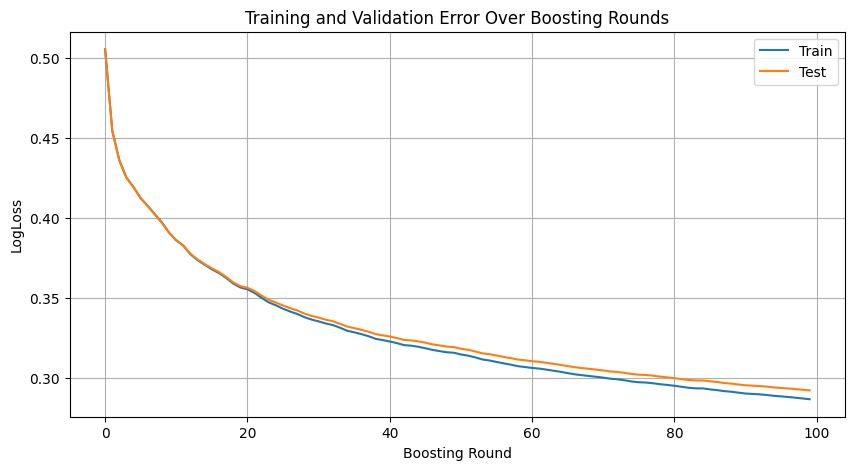

In [8]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Use the best parameters from the Bayesian optimization
print("Best parameters found:", best_params)

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic", random_state=42, n_estimators=100, **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

## N_Estimators and Early stopping

In [9]:
# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:46:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(alpha=2.0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.6, eval_metric='logloss',
              feature_types=None, gamma=0.0, grow_policy=None,
              importance_type=None, interaction_constraints=None, lambda_=0.0,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=2000, ...)

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [15:54:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


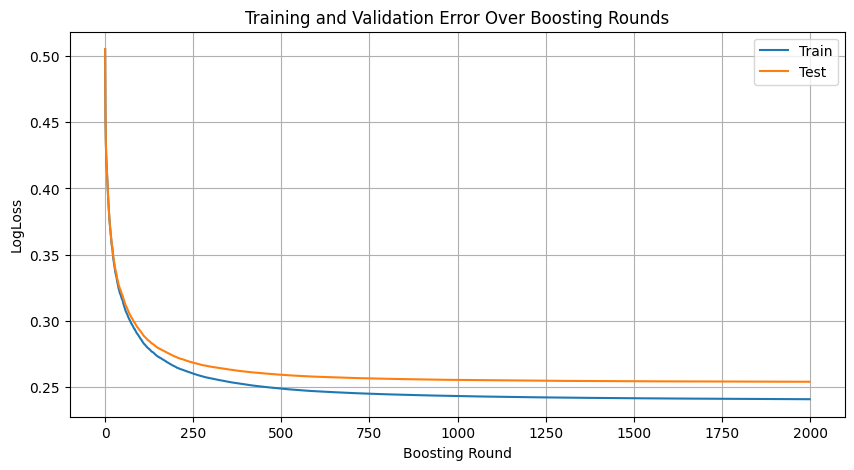

In [10]:
# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/Users/emiljino/anaconda3/envs/Diss2/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [16:03:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


Best iteration: 1997


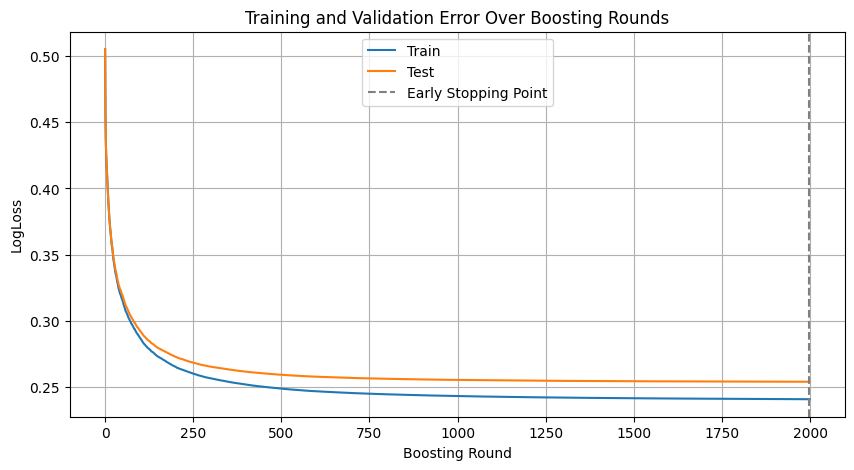

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.714937 to fit


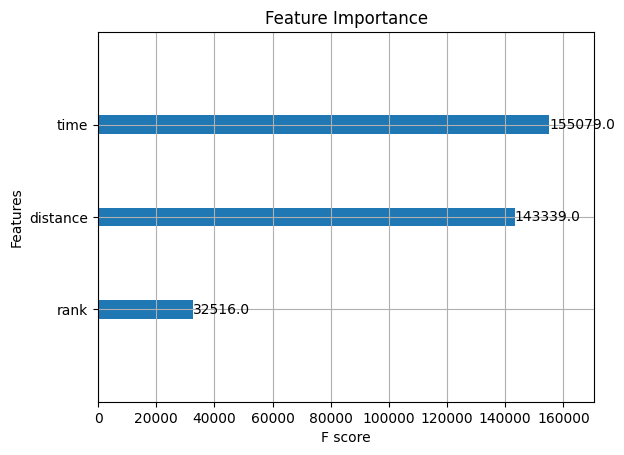

    Feature  Importance
3      rank    0.801078
2  distance    0.103945
0      time    0.094977
1     stake    0.000000


In [11]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Convert the booster to scikit-learn format using best parameters
best_xgb_estimator = xgb.XGBClassifier(
    objective="binary:logistic",
    random_state=42,
    n_estimators=2000,  # Increasing n_estimators to 2000
    **best_params,
)

# Evaluate the model's performance on train and test datasets during training
eval_set = [(X_train, y_train), (X_test, y_test)]
best_xgb_estimator.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    early_stopping_rounds=20,  # Increasing early stopping rounds to 20
    verbose=False,
)

# 1. Print the boosting round where early stopping occurred:
print(f"Best iteration: {best_xgb_estimator.get_booster().best_iteration}")

# Extract and plot the training and test logloss over boosting rounds
results = best_xgb_estimator.evals_result()
train_errors = results["validation_0"]["logloss"]
test_errors = results["validation_1"]["logloss"]

plt.figure(figsize=(10, 5))
plt.plot(train_errors, label="Train")
plt.plot(test_errors, label="Test")
plt.axvline(
    x=best_xgb_estimator.get_booster().best_iteration,
    color="gray",
    linestyle="--",
    label="Early Stopping Point",
)
plt.xlabel("Boosting Round")
plt.ylabel("LogLoss")
plt.title("Training and Validation Error Over Boosting Rounds")
plt.legend()
plt.grid(True)
plt.show()

# 2. Visualize the model using XGBoost's plot functionalities:

# a. Plotting the first tree:
xgb.plot_tree(best_xgb_estimator, num_trees=0)
plt.show()

# b. Displaying the importance of each feature:
xgb.plot_importance(best_xgb_estimator)
plt.title("Feature Importance")
plt.show()

# Feature importances:
importances = best_xgb_estimator.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame(
    {"Feature": features, "Importance": importances}
).sort_values(by="Importance", ascending=False)
print(feature_importance_df)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89    248200
           1       0.88      0.87      0.87    230980

    accuracy                           0.88    479180
   macro avg       0.88      0.88      0.88    479180
weighted avg       0.88      0.88      0.88    479180

[[221583  26617]
 [ 30843 200137]]


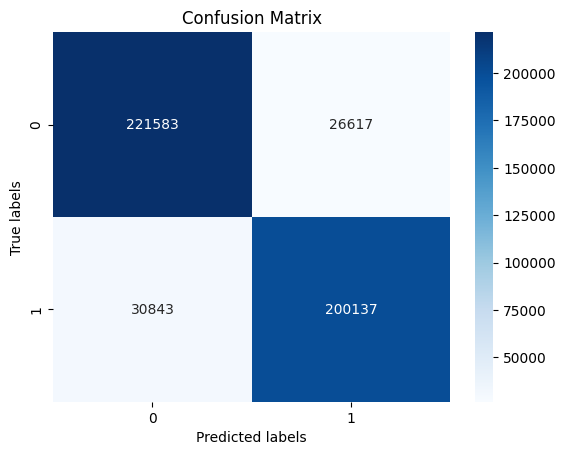

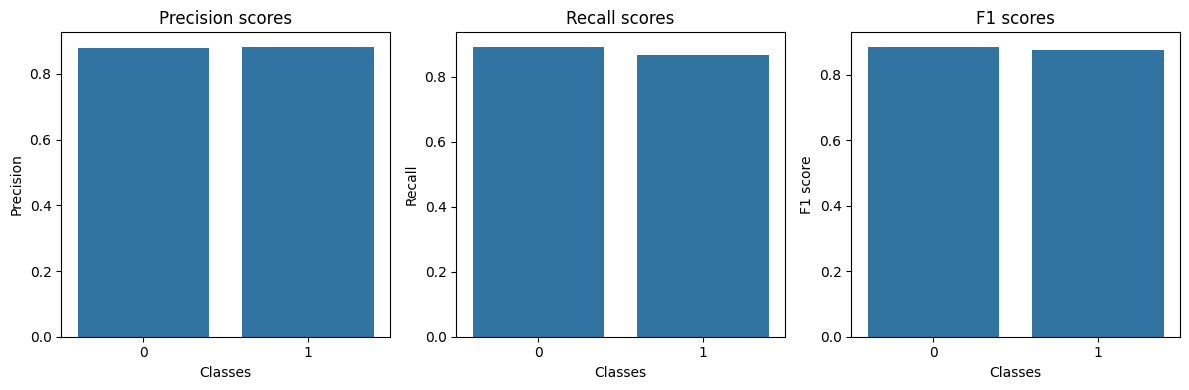

In [12]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predict the classes
y_pred = best_xgb_estimator.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
print(confusion_matrix(y_test, y_pred))

# Visualizing the Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="g", cmap="Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Precision, recall, f1-score plots for each class
precision, recall, f1score, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None
)

plt.figure(figsize=(12, 4))

plt.subplot(131)
sns.barplot(x=np.unique(y_test), y=precision)
plt.title("Precision scores")
plt.xlabel("Classes")
plt.ylabel("Precision")

plt.subplot(132)
sns.barplot(x=np.unique(y_test), y=recall)
plt.title("Recall scores")
plt.xlabel("Classes")
plt.ylabel("Recall")

plt.subplot(133)
sns.barplot(x=np.unique(y_test), y=f1score)
plt.title("F1 scores")
plt.xlabel("Classes")
plt.ylabel("F1 score")

plt.tight_layout()
plt.show()

## Saving the model


In [13]:
# Save the best model to a .json file
best_model.save_model("Trained_XGB4_model.json")

## Merging logloss files

In [13]:
from PIL import Image, ImageDraw, ImageFont


def combine_images(file_paths, titles, output_path="combined_logloss.png"):
    images = [Image.open(x) for x in file_paths]

    # Assuming all images are the same size
    widths, heights = zip(*(i.size for i in images))

    # Specify the layout of the subplots
    total_width = max(widths) * 2  # Adjusted for 3 columns
    total_height = max(heights) * 3  # Adjusted for 2 rows

    # Create a new image with a white background
    new_im = Image.new("RGB", (total_width, total_height), "white")

    # Positions of the images in the grid
    positions = [
        (0, 0),
        (max(widths), 0),
        (0, max(heights)),
        (max(widths), max(heights)),
        (0, 2 * max(heights)),  # New position for 1st image in 3rd row
        (max(widths), 2 * max(heights)),  # New position for 2nd image in 3rd row
    ]

    # Draw the images and titles
    for pos, img, title in zip(positions, images, titles):
        new_im.paste(img, pos)
        draw = ImageDraw.Draw(new_im)
        font = font = ImageFont.truetype(
            "/Library/Fonts/Arial.ttf", 20
        )  # Adjust font and size as needed
        draw.text(
            (pos[0], pos[1]), title, (0, 0, 0), font=font
        )  # Adjust color as needed

    new_im.save(output_path)


# List of image paths in order
file_paths = [
    "/Users/emiljino/Library/Mobile Documents/com~apple~CloudDocs/Year 4/Individual project with Innovation Case/Images/XGBRepLogLoss.png",
    "/Users/emiljino/Library/Mobile Documents/com~apple~CloudDocs/Year 4/Individual project with Innovation Case/Images/XGB1LogLoss.png",
    "/Users/emiljino/Library/Mobile Documents/com~apple~CloudDocs/Year 4/Individual project with Innovation Case/Images/XGB2LogLoss.png",
    "/Users/emiljino/Library/Mobile Documents/com~apple~CloudDocs/Year 4/Individual project with Innovation Case/Images/XGB3LogLoss.png",
    "/Users/emiljino/Library/Mobile Documents/com~apple~CloudDocs/Year 4/Individual project with Innovation Case/Images/XGB4LogLoss.png",
]

# Titles for the images
titles = ["XGB Rep", "XGB1", "XGB2", "XGB3", "XGB4"]

combine_images(file_paths, titles)